In [1]:
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt

In [76]:
creds = pd.read_csv("creds.csv", header=None, index_col=0)[1].to_dict()
conn = psycopg2.connect(**creds)

In [84]:
# my_query = """
#             SELECT *
#             FROM datamart.volante_mobile_transactions
#             """

my_query = """
            SELECT mealplanname,transactioncctype,payment_method_key, count(distinct(orderid)) as orders
            FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
            WHERE trunc(createddate) >= '2022-01-01'
            GROUP BY mealplanname,transactioncctype,payment_method_key
            """

my_2nd_query = """
                SELECT payment_method_key, count(distinct(orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY payment_method_key
                """

### Similar to my_2nd_query, except I truncate the "/_" from the payment_method_key strings to keep just the common identifer names
my_2nd_query_2 = """
                SELECT cast(split_part(payment_method_key,'/',1) as text) as payment_method_key, count(distinct(orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY payment_method_key
                """

my_3rd_query = """
                SELECT payment_method_key, count(distinct(orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                WHERE trunc(createddate) >= '2019-10-01'
                GROUP BY payment_method_key
                """

my_4th_query = """
                SELECT payment_method_key, paymenttype, count(distinct(o.orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                     left join datastore.mobile_orders m on o.orderid = m.orderid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY payment_method_key, paymenttype  
                """

my_5th_query = """
                SELECT m.static_locationname, payment_method_key, mealplanname, transactioncctype, count(distinct(o.orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                left join datastore.mobile_orders m on o.orderid = m.orderid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY m.static_locationname, payment_method_key, mealplanname, transactioncctype
                """

my_6th_query = """
                SELECT m.static_locationname,
                        cast(split_part(payment_method_key,'/',1) as text) as payment_method_key,
                        paymenttype,
                        CASE
                            WHEN payment_method_key LIKE '%credit_card%' THEN 'Cash/Credit'
                            WHEN payment_method_key LIKE '%digital_wallet_pay%' THEN 'Cash/Credit'
                            WHEN payment_method_key LIKE '%meal_swipes%' THEN 'Meal Equivalency'
                            WHEN payment_method_key LIKE '%meal_exchange%' THEN 'Meal Exchange'
                            WHEN payment_method_key LIKE '%mealplan%' THEN 'Declining Balance'
                            ELSE 'Unknown'
                            END AS payment_type,
                        count(distinct(o.orderid)) as orders
                            
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                left join datastore.mobile_orders m on o.orderid = m.orderid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY m.static_locationname, payment_method_key, paymenttype, payment_type
                """

my_6th_queryBeta = """
                SELECT m.static_locationname,
                        cast(split_part(payment_method_key,'/',1) as text) as payment_method_key,
                        paymenttype,
                        CASE
                            WHEN payment_method_key LIKE '%credit_card%' THEN 'Cash/Credit'
                            WHEN payment_method_key LIKE '%digital_wallet_pay%' THEN 'Cash/Credit'
                            WHEN payment_method_key LIKE '%meal_swipes%' THEN 'Meal Equivalency'
                            WHEN payment_method_key LIKE '%meal_exchange%' THEN 'Meal Exchange'
                            WHEN payment_method_key LIKE '%mealplan%' THEN 'Declining Balance'
                            WHEN payment_method_key IS NULL AND (
                                                                    paymenttype LIKE '%Visa%' OR 
                                                                    paymenttype LIKE '%visa%' OR 
                                                                    paymenttype LIKE '%VISA%' OR 
                                                                    paymenttype LIKE '%MasterCard%' OR
                                                                    paymenttype LIKE '%AmericanExpress%' OR
                                                                    paymenttype LIKE '%American Express%' OR
                                                                    paymenttype LIKE '%AMEX%' OR
                                                                    paymenttype LIKE '%Ax%' OR
                                                                    paymenttype LIKE '%Discover%') THEN 'Cash/Credit'
                            WHEN payment_method_key IS NULL AND (paymenttype LIKE '%Meal Exchanges%') THEN 'Meal Exchange'
                            WHEN payment_method_key IS NULL AND (
                                                                    paymenttype LIKE '%Dollar%' OR
                                                                    paymenttype LIKE '%Dollars%' OR
                                                                    paymenttype LIKE '%dollar%' OR
                                                                    paymenttype LIKE '%Dollars%' OR
                                                                    paymenttype LIKE '%DOLLAR%' OR
                                                                    paymenttype LIKE '%DOLLARS%' OR
                                                                    paymenttype LIKE '%Cash%' OR
                                                                    paymenttype LIKE '%cash%' OR
                                                                    paymenttype LIKE '%CASH%' OR
                                                                    paymenttype LIKE '%Buck%' OR
                                                                    paymenttype LIKE '%buck%' OR
                                                                    paymenttype LIKE '%BUCK%' OR
                                                                    paymenttype LIKE '%Bucks%' OR
                                                                    paymenttype LIKE '%bucks%' OR
                                                                    paymenttype LIKE '%BUCKS%' OR
                                                                    paymenttype LIKE '%flex%' OR
                                                                    paymenttype LIKE '%Flex%' OR
                                                                    paymenttype LIKE '%FLEX%') THEN 'Declining Balance'
                            ELSE 'Unknown'
                            END AS payment_type,
                        count(distinct(o.orderid)) as orders
                            
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                left join datastore.mobile_orders m on o.orderid = m.orderid
                WHERE trunc(createddate) >= '2022-01-01'
                GROUP BY m.static_locationname, payment_method_key, paymenttype, payment_type
                """

my_6th_queryCharlie = """
SELECT m.static_locationname,
        paymenttype as mobileorders_paymenttype,
        cast(split_part(payment_method_key,'/',1) as text) as payment_method_key,
        CASE
            WHEN m.sourcedb = 'p2' and payment_method_key LIKE '%credit_card%' THEN 'Cash/Credit'
            WHEN m.sourcedb = 'p2' and payment_method_key LIKE '%digital_wallet_pay%' THEN 'Cash/Credit'
            WHEN m.sourcedb = 'p2' and payment_method_key LIKE '%meal_swipes%' THEN 'Meal Equivalency'
            WHEN m.sourcedb = 'p2' and payment_method_key LIKE '%meal_exchange%' THEN 'Meal Exchange'
            WHEN m.sourcedb = 'p2' and payment_method_key LIKE '%mealplan%' THEN 'Declining Balance'
            WHEN m.sourcedb = 'p2' and payment_method_key IS NULL AND (
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'visa' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'mastercard' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'amex' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'americanexpress' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'discover' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'applepaycredit' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'giftcard' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'debit') THEN 'Cash/Credit'
            WHEN m.sourcedb = 'p2' and payment_method_key IS NULL AND (REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'mealexchanges') THEN 'Meal Exchange'
            WHEN m.sourcedb <> 'p2' and (
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'visa' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'mastercard' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'amex' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'americanexpress' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'discover' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'applepaycredit' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'giftcard' OR
                                            REPLACE(LOWER(mobileorders_paymenttype), ' ','') = 'debit') THEN 'Cash/Credit'
            ELSE 'Unknown'
            END AS payment_categorization,
                count(distinct(o.orderid)) as orders
FROM datastore.mobile_orders m
left join datamart.p2_order_item_options o on m.orderid = o.orderid
left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
WHERE trunc(orderdate) >= '2022-01-01'
GROUP BY m.static_locationname, payment_method_key, mobileorders_paymenttype, payment_categorization
"""

In [85]:
df_test = pd.read_sql(my_query, conn)
df_test

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,static_locationname,mobileorders_paymenttype,payment_method_key,payment_categorization,orders
0,Trent University,Taxable Dining,mealplan,Declining Balance,3521
1,Universal Studios Lot,MasterCard,credit_card,Cash/Credit,446
2,VISA Denver,Visa,credit_card,Cash/Credit,3491
3,BNY Mellon Greenwich,N/A,None,Unknown,204
4,Dutchess CC,Dutchess Dollars,mealplan,Declining Balance,7218
...,...,...,...,...,...
8724,Deer Lake Cafe 3,None,None,Unknown,0
8725,Continental North,Discover,None,Cash/Credit,0
8726,Polaris Wyoming,MasterCard,None,Cash/Credit,0
8727,Northeastern University,Profiler Meal Plan,mealplan,Declining Balance,1


In [86]:
df_test[df_test['payment_categorization']=='Unknown']#.sourcedb.unique()

,static_locationname,mobileorders_paymenttype,payment_method_key,payment_categorization,orders
3,BNY Mellon Greenwich,N/A,None,Unknown,204
161,Visa Foster City,N/A,None,Unknown,425
421,Sanford Cafe,None,None,Unknown,0
476,Quantum Park Ashburn,None,None,Unknown,0
510,Limetree Bay,None,None,Unknown,0
...,...,...,...,...,...
8690,Westown Cafe,None,None,Unknown,0
8709,University of Wisconsin - La Crosse,Big Eagle Blocks,None,Unknown,1
8718,Ekman Cafe,None,None,Unknown,0
8723,Prisma - Hillcrest,None,None,Unknown,0


In [7]:
print("Total number of unique transactions:",len(df_test))
print("")
print("Unique payment methods:",df_test.payment_method_key.unique())
print("")
print("Unique payment methods:\n",df_test.payment_method_key.value_counts())
print("")
print("Transactions with None as Payment method:",df_test.payment_method_key.isna().sum())

Total number of unique transactions: 866

Unique payment methods: ['mealplan/id' 'digital_wallet_pay/wallet_type' 'mealplan/tender'
 'credit_card/last4' 'meal_exchange/id' 'mealplan/total'
 'digital_wallet_pay/total' 'meal_swipes/tender_name' 'meal_swipes/swipes'
 'meal_swipes/id' 'meal_swipes/rate' 'meal_swipes/tender'
 'credit_card/card_type' 'meal_exchange/tender' 'credit_card/total' None
 'meal_swipes/total' 'meal_swipes/tender_type']

Unique payment methods:
 mealplan/id                       196
mealplan/tender                   196
mealplan/total                    196
meal_exchange/id                   43
meal_exchange/tender               43
credit_card/last4                  28
credit_card/card_type              28
meal_swipes/tender                 19
meal_swipes/id                     19
credit_card/total                  18
meal_swipes/swipes                  9
meal_swipes/rate                    9
meal_swipes/tender_name             9
meal_swipes/tender_type             9

In [41]:
### Check if total counts add up to length of Data-frame
196+196+196+43+43+28+28+19+19+18+9+9+9+9+8+6+6+24

866

### payment types and their frequency counts from Jan 1st 2022 onwards

In [60]:
df_new = pd.read_sql(my_2nd_query, conn)
df_new

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,payment_method_key,orders
0,mealplan/id,486845
1,digital_wallet_pay/wallet_type,195644
2,meal_swipes/total,21790
3,digital_wallet_pay/total,26789
4,mealplan/tender,486845
5,credit_card/card_type,554830
6,credit_card/last4,554830
7,None,24076
8,meal_swipes/id,77932
9,meal_swipes/swipes,21846


In [73]:
df_new.payment_method_key.fillna(value="Unknown", inplace=True)
df_new

In [74]:
df_new

,payment_method_key,orders
0,credit_card/last4,2930832
1,mealplan/tender,2863908
2,Unknown,256824
3,credit_card/card_type,2930832
4,meal_swipes/id,160747
5,meal_swipes/swipes,53998
6,meal_swipes/tender,160747
7,mealplan/id,2863908
8,digital_wallet_pay/wallet_type,832431
9,meal_exchange/tender,320386


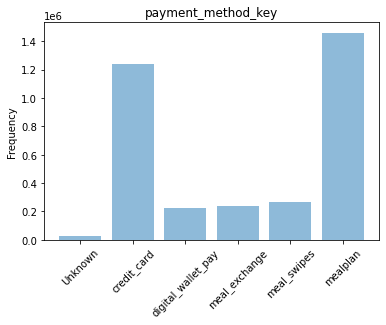

In [64]:
df_new['payment_method_key'] = df_new['payment_method_key'].str.split('/').str[0]
df_new_cp = copy.deepcopy(df_new)
df_new_cp=df_new_cp.groupby(['payment_method_key']).agg('sum').reset_index()

plt.figure()
objects = df_new_cp['payment_method_key']
y_pos = np.arange(len(objects))
performance = df_new_cp['orders']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation = (45), fontsize = 10)
plt.ylabel('Frequency')
plt.title('payment_method_key')
# plt.xticks(, va='bottom', ha='left')
plt.show()
# df_new_cp.plot.hist(column=['payment_method_key'])

### payment types and their frequency counts from Oct 1st 2019 onwards

In [4]:
df_new_new = pd.read_sql(my_3rd_query, conn)
df_new_new

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


DatabaseError: Execution failed on sql: 
                SELECT payment_method_key, count(distinct(orderid)) as orders
                FROM datamart.p2_order_item_options o left join source.p2_shopping_cart_payment_methods p on o.apishoppingcartid = p.shoppingcartid
                WHERE trunc(createddate) >= '2019-10-01'
                GROUP BY payment_method_key
                
SSL SYSCALL error: EOF detected

unable to rollback

In [ ]:
print("Table loaded into dataframe")

In [ ]:
df_new_new.payment_method_key.fillna(value="Unknown", inplace=True)
df_new_new

In [74]:
df_new_new

,payment_method_key,orders
0,credit_card/last4,2930832
1,mealplan/tender,2863908
2,Unknown,256824
3,credit_card/card_type,2930832
4,meal_swipes/id,160747
5,meal_swipes/swipes,53998
6,meal_swipes/tender,160747
7,mealplan/id,2863908
8,digital_wallet_pay/wallet_type,832431
9,meal_exchange/tender,320386


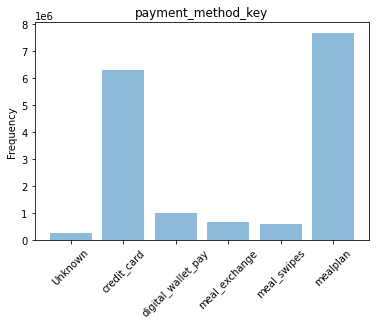

In [75]:
df_new_new['payment_method_key'] = df_new_new['payment_method_key'].str.split('/').str[0]
df_new_cp = copy.deepcopy(df_new_new)
df_new_cp=df_new_cp.groupby(['payment_method_key']).agg('sum').reset_index()

plt.figure()
objects = df_new_cp['payment_method_key']
y_pos = np.arange(len(objects))
performance = df_new_cp['orders']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation = (45), fontsize = 10)
plt.ylabel('Frequency')
plt.title('payment_method_key')
# plt.xticks(, va='bottom', ha='left')
plt.show()
# df_new_cp.plot.hist(column=['payment_method_key'])

### Pulling Top 10 payment types for each of the "key" payment methods

In [7]:
df_new4 = pd.read_sql(my_4th_query, conn)
df_new4

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,payment_method_key,paymenttype,orders
0,None,MasterCard,5762
1,digital_wallet_pay/wallet_type,MasterCard,32467
2,digital_wallet_pay/total,MasterCard,4824
3,mealplan/total,Meal Swipe,21738
4,mealplan/tender,Tax Exempt Dining,37749
...,...,...,...
667,None,Babson Bucks - Student,1
668,mealplan/tender,Flex Fund,2
669,mealplan/tender,Fall 17,1
670,mealplan/total,Maroon Dollars/Meal Points,2


In [8]:
df_new4.payment_method_key.fillna(value="Unknown", inplace=True)
df_new4.paymenttype.fillna(value="Unknown", inplace=True)
df_new4['payment_method_key'] = df_new4['payment_method_key'].str.split('/').str[0]
df_new4

,payment_method_key,paymenttype,orders
0,Unknown,MasterCard,5762
1,digital_wallet_pay,MasterCard,32467
2,digital_wallet_pay,MasterCard,4824
3,mealplan,Meal Swipe,21738
4,mealplan,Tax Exempt Dining,37749
...,...,...,...
667,Unknown,Babson Bucks - Student,1
668,mealplan,Flex Fund,2
669,mealplan,Fall 17,1
670,mealplan,Maroon Dollars/Meal Points,2


In [9]:
df_new4_cp = copy.deepcopy(df_new4)

# ## Some duplicate rows observed, will pnly keep first occurrence and drop rest
# df_new4_cp = df_new4_cp.drop_duplicates()
df_new4_cp

,payment_method_key,paymenttype,orders
0,Unknown,MasterCard,5762
1,digital_wallet_pay,MasterCard,32467
2,digital_wallet_pay,MasterCard,4824
3,mealplan,Meal Swipe,21738
4,mealplan,Tax Exempt Dining,37749
...,...,...,...
667,Unknown,Babson Bucks - Student,1
668,mealplan,Flex Fund,2
669,mealplan,Fall 17,1
670,mealplan,Maroon Dollars/Meal Points,2


In [10]:
df_new4_cp = df_new4_cp.groupby(['payment_method_key','paymenttype']).agg('sum')
df_new4_cp

orders
payment_method_key paymenttype                      
Unknown            14 Meals Per Week               1
                   154 - Premier Unlim             5
                   155 -Block                      2
                   160 Block Plan                  7
                   American Express              718
...                                              ...
mealplan           Viking Gold                   246
                   Visa                           27
                   Winter Flex                    24
                   Wolfbucks                      36
                   Yotie Eats Dining Dollars     651

[242 rows x 1 columns]

In [11]:
payment_methods = list(df_new4_cp.reset_index()['payment_method_key'].unique())
for i in payment_methods:
    print(i)

Unknown
credit_card
digital_wallet_pay
meal_exchange
meal_swipes
mealplan


In [27]:
df_new4_cp.loc['digital_wallet_pay'].reset_index().sort_values(by='orders', ascending=False)

,paymenttype,orders
6,Visa,112897
4,N/A,45434
2,MasterCard,37291
0,American Express,18502
1,Discover,9945
3,Meal Swipe,268
5,Unknown,66


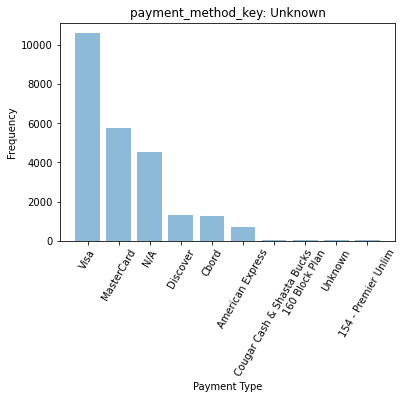

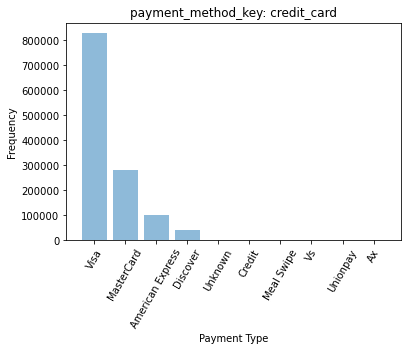

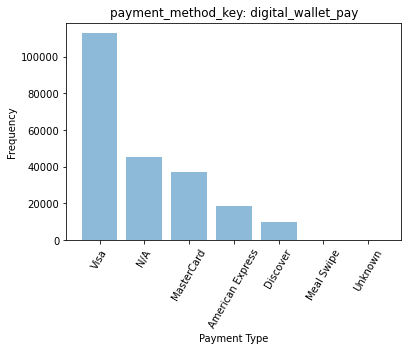

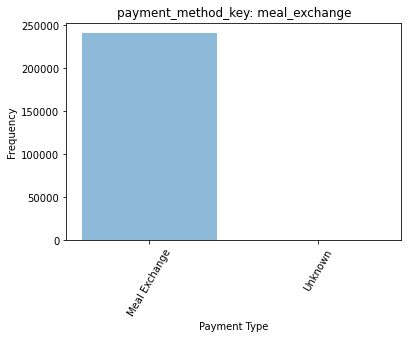

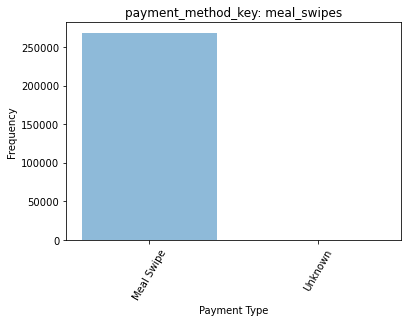

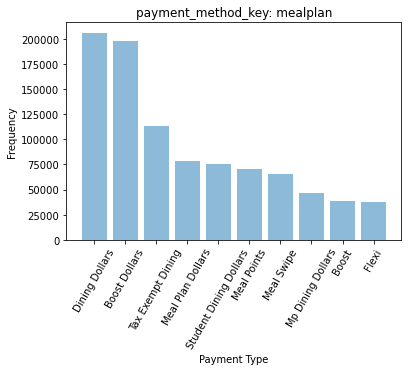

In [26]:
payment_methods = list(df_new4_cp.reset_index()['payment_method_key'].unique())
for i in payment_methods:
    plt.figure()
    
    objects = df_new4_cp.loc[i].reset_index().sort_values(by='orders', ascending=False)['paymenttype'][:10]
    y_pos = np.arange(len(objects))
    performance = df_new4_cp.loc[i].reset_index().sort_values(by='orders', ascending=False)['orders'][:10]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation = (60), fontsize = 10)
    plt.ylabel('Frequency')
    plt.xlabel('Payment Type')
    plt.title('payment_method_key: '+str(i))

### Exploring Categorization logic

### New logic

#### cash/credit <-- digital_wallet_pay(excluding swipes and exchange and list1 substrings) + credit_card(excluding meal substring)
#### Declining_Balance <-- mealplan
#### Meal Equivalence <-- meal_swipes + Unknown(with meal_swipes) + digital_wallet_pay(with meal_swipes) + credit_card(with Meal Swipe)
#### Meal Exchange <-- meal_exchange + Unknown(with meal_exchange)
#### Unknown <-- Unknown Unknown Unknowns

In [30]:
df_new5 = pd.read_sql(my_5th_query, conn)
df_new5

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,static_locationname,payment_method_key,mealplanname,transactioncctype,orders
0,Trent University,mealplan/tender,Tax Exempt Dining,None,37813
1,Sacred Heart University,mealplan/tender,Dining Dollars,None,23856
2,University of Utah,meal_swipes/tender_name,Flex Dollars,Meal Swipe,1586
3,Colgate University,meal_exchange/id,154 - Premier Unlim,Meal Exchange,41410
4,Eastern CT State,mealplan/total,DINING DOLLARS,None,571
...,...,...,...,...,...
7089,AstraZeneca Mt. Vernon,digital_wallet_pay/wallet_type,None,N/A,1
7090,QA University,mealplan/total,Tax Exempt Dining,None,1
7091,Exxon Mobil Clinton,digital_wallet_pay/total,None,Discover,1
7092,Zebra Technologies,None,None,American Express,2


In [31]:
df_new5.payment_method_key.fillna(value="Unknown", inplace=True)
df_new5.mealplanname.fillna(value="Unknown", inplace=True)
df_new5.transactioncctype.fillna(value="Unknown", inplace=True)
df_new5['payment_method_key'] = df_new5['payment_method_key'].str.split('/').str[0]
df_new5

,static_locationname,payment_method_key,mealplanname,transactioncctype,orders
0,Trent University,mealplan,Tax Exempt Dining,Unknown,37813
1,Sacred Heart University,mealplan,Dining Dollars,Unknown,23856
2,University of Utah,meal_swipes,Flex Dollars,Meal Swipe,1586
3,Colgate University,meal_exchange,154 - Premier Unlim,Meal Exchange,41410
4,Eastern CT State,mealplan,DINING DOLLARS,Unknown,571
...,...,...,...,...,...
7089,AstraZeneca Mt. Vernon,digital_wallet_pay,Unknown,N/A,1
7090,QA University,mealplan,Tax Exempt Dining,Unknown,1
7091,Exxon Mobil Clinton,digital_wallet_pay,Unknown,Discover,1
7092,Zebra Technologies,Unknown,Unknown,American Express,2


In [70]:
df_new5['payment_type'] = df_new5[['mealplanname', 'transactioncctype']].agg('-'.join, axis=1)
df_new5

,static_locationname,payment_method_key,mealplanname,transactioncctype,orders,payment_type
0,Trent University,mealplan,Tax Exempt Dining,Unknown,37813,Tax Exempt Dining-Unknown
1,Sacred Heart University,mealplan,Dining Dollars,Unknown,23856,Dining Dollars-Unknown
2,University of Utah,meal_swipes,Flex Dollars,Meal Swipe,1586,Flex Dollars-Meal Swipe
3,Colgate University,meal_exchange,154 - Premier Unlim,Meal Exchange,41410,154 - Premier Unlim-Meal Exchange
4,Eastern CT State,mealplan,DINING DOLLARS,Unknown,571,DINING DOLLARS-Unknown
...,...,...,...,...,...,...
7089,AstraZeneca Mt. Vernon,digital_wallet_pay,Unknown,N/A,1,Unknown-N/A
7090,QA University,mealplan,Tax Exempt Dining,Unknown,1,Tax Exempt Dining-Unknown
7091,Exxon Mobil Clinton,digital_wallet_pay,Unknown,Discover,1,Unknown-Discover
7092,Zebra Technologies,Unknown,Unknown,American Express,2,Unknown-American Express


In [68]:
dec_bal, rem_bal = [], []
mealplannames = df_new5.mealplanname.unique()
list1 = ['Dollar','Dollars','dollar','dollars','DOLLAR','DOLLARS','Buck','buck','Bucks','bucks','flex','Flex','FLEX','Declining Balance']

for mealplan in mealplannames:
    if any(substring in mealplan for substring in list1):
        dec_bal.append(mealplan)
    else:
        rem_bal.append(mealplan)

print(len(dec_bal))
print(len(np.unique(mealplannames)))

93
226


In [ ]:
# for rem in rem_bal:
#     print(rem)
#     print(df_new5['static_locationname'].loc[df_new5['mealplanname'] == rem].to_list())
#     print("")

df_new5_cp = copy.deepcopy(df_new5)
df_new5_cp = df_new5_cp[['static_locationname','mealplanname','orders']].groupby(['static_locationname','mealplanname']).agg('sum')
campuses = df_new5_cp.reset_index()['static_locationname'].unique()
for campus in campuses:
    print(campus)
    print(df_new5_cp.loc[campus].reset_index().sort_values(by='orders', ascending=False)['mealplanname'].to_list())
    print("")

### Testing final Mobile P2 and non-P2 site Payment Categorization

In [85]:
df_new6 = pd.read_sql(my_6th_queryCharlie, conn)
df_new6

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,static_locationname,mobileorders_paymenttype,payment_method_key,payment_categorization,orders
0,Trent University,Taxable Dining,mealplan,Declining Balance,3521
1,Universal Studios Lot,MasterCard,credit_card,Cash/Credit,446
2,VISA Denver,Visa,credit_card,Cash/Credit,3491
3,BNY Mellon Greenwich,N/A,None,Unknown,204
4,Dutchess CC,Dutchess Dollars,mealplan,Declining Balance,7218
...,...,...,...,...,...
8724,Deer Lake Cafe 3,None,None,Unknown,0
8725,Continental North,Discover,None,Cash/Credit,0
8726,Polaris Wyoming,MasterCard,None,Cash/Credit,0
8727,Northeastern University,Profiler Meal Plan,mealplan,Declining Balance,1


In [86]:
df_new6[df_new6['payment_categorization']=='Unknown']#.sourcedb.unique()

,static_locationname,mobileorders_paymenttype,payment_method_key,payment_categorization,orders
3,BNY Mellon Greenwich,N/A,None,Unknown,204
161,Visa Foster City,N/A,None,Unknown,425
421,Sanford Cafe,None,None,Unknown,0
476,Quantum Park Ashburn,None,None,Unknown,0
510,Limetree Bay,None,None,Unknown,0
...,...,...,...,...,...
8690,Westown Cafe,None,None,Unknown,0
8709,University of Wisconsin - La Crosse,Big Eagle Blocks,None,Unknown,1
8718,Ekman Cafe,None,None,Unknown,0
8723,Prisma - Hillcrest,None,None,Unknown,0


In [ ]:
### Query needs to be updated to include sourcedb, mealplanname, and transactioncctype for this cell to run
df_test_cp = df_new6[~pd.isnull(df_new6)]
df_test_cp = copy.deepcopy(df_new6[['sourcedb','payment_method_key','mobileorders_paymenttype','mealplanname','transactioncctype','payment_categorization','orders']])
# temp = df_test_cp.groupby(['payment_categorization','mealplanname','mobileorders_paymenttype','sourcedb']).agg("count")
# df_temp = temp.loc['Unknown'].reset_index()#['mobileorders_paymenttype'].unique()#.sort_values(by='orders', ascending=False)
df_test_cp[df_test_cp['payment_categorization']=='Unknown'][250:300]